# (Fa)cial (La)ndmarks (Tra)cking demo

This notebook demonstates a technique to re-project a set of a pre-defined 3D facial landmarks from a textured 3D model of a human subject, to a different 3D model of the same subject.

The general idea is that we will use an expensive high-fidelity camera to capture a textured head model of a subject, and use ordinary cameras to re-construct a lower fidelity model of the same subject. We can then use photogrammetry technique to re-project landmarks defined w.r.t to our high-fidelity model to our low-fidelity model.

Notes:
* We are not doing any landmarks detection. Those landmarks are already pre-defined using the CliniFace software w.r.t to our high fidelity model
* The models we're comparing are subjected to non-rigd deformation of their spatial geometry. I.E Model A can capture the subject when they have their mouths opened, and model B captures the same subject but they have their mouth closed.
* We're not trying to do this in real time so it doesn't have to be fast.

## Algorithm overview

1. An initial high-fidelity 3D textured model of the subject is created using a Vectra H1 camera, and a set of landmarks w.r.t to the model is pre-defined using the Cliniface software.

2. WIP


In [1]:
import os
import pickle

import cv2
from matplotlib import pyplot as plt
import numpy as np

from falatra.utils import find_bbox_centre, distance_from_line
from falatra.keypoints import Frame, FrameMatcher
from falatra.model.head3d import deserialize_headmodel, HeadModel3D
from falatra.model.stereo import StereoCalibration
from falatra.markers import MarkerDetection

%matplotlib notebook

## Load head model

Interesting Files:
* ./create_headmodel.py: Generate a new headmodel manually using a VTK GUI
* ./falatra/models/head3d.py: Contains HeadModel class

A Headmodel stores a set of SIFT keypoints detected from a 2D image projection of the textured mesh, and then re-projected to 3D by shooting a ray into a graphics window at each keypoints image coordinate and intersecting with actor's defining geometry - specifically its points in world coordinates.

The results can be seen below

<IPython.core.display.Javascript object>


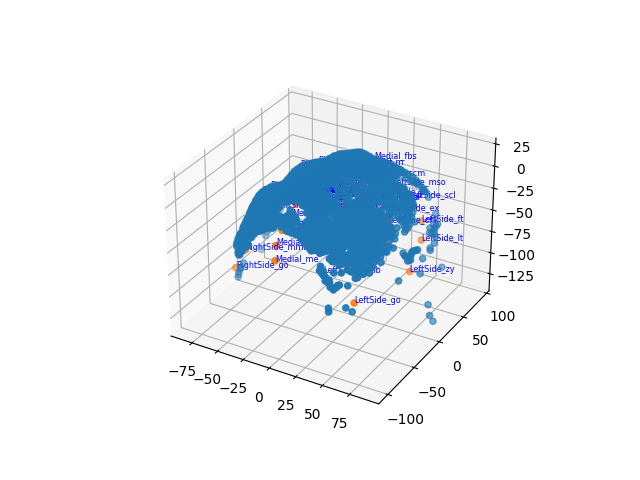

<IPython.core.display.Javascript object>


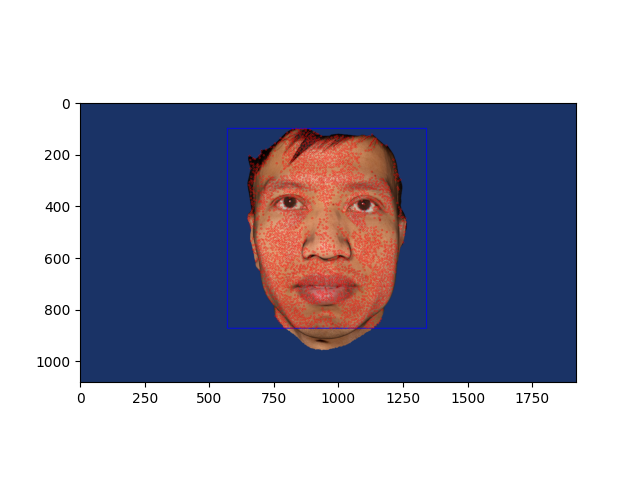

<IPython.core.display.Javascript object>


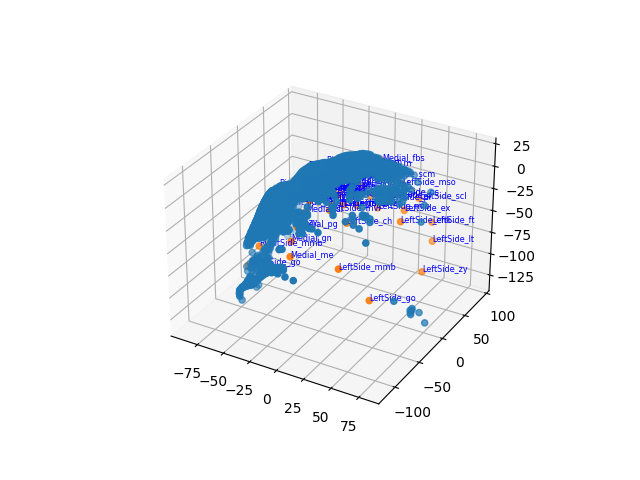

<IPython.core.display.Javascript object>


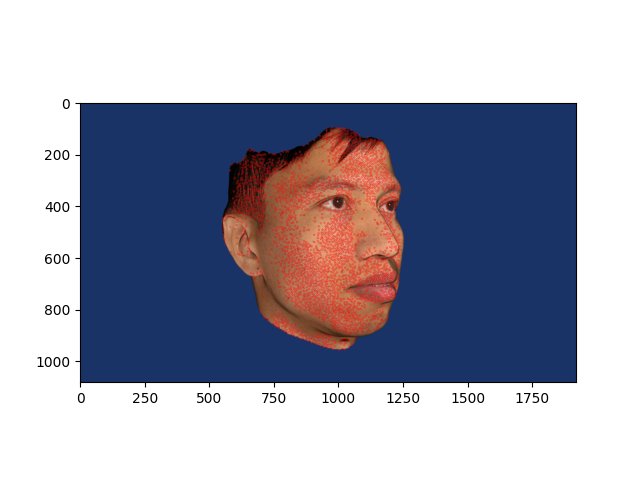

In [2]:
headmodel_front = deserialize_headmodel('./data/headmodelfront.ser')
headmodel_side  = deserialize_headmodel('./data/headmodelleft.ser')

with open('./data/framefront.ser', 'rb') as fp:
    modelframe_front = pickle.load(fp)
    
with open('./data/frameside.ser', 'rb') as fp:
    modelframe_side = pickle.load(fp)

headmodel_front.display()
modelframe_front.display()
headmodel_side.display()
modelframe_side.display()


## Camera Calibration


In [3]:
calibration = StereoCalibration()
calibration.load('./data/calibration/calibration1')
print(calibration)

cam_mats:
{'left': array([[1.30039824e+04, 0.00000000e+00, 7.36642022e+02],
       [0.00000000e+00, 1.30039824e+04, 8.35341114e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]), 'right': array([[1.30039824e+04, 0.00000000e+00, 7.15671183e+02],
       [0.00000000e+00, 1.30039824e+04, 8.57512851e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])}
dist_coefs:
{'left': array([[ 8.09677167e-01, -3.11992742e+02,  0.00000000e+00,
         0.00000000e+00,  1.06225917e+04]]), 'right': array([[-3.49236551e+00, -1.37430168e+02,  0.00000000e+00,
         0.00000000e+00,  1.35454591e+04]])}
rot_mat:
[[ 0.67712856 -0.11311647 -0.72711868]
 [ 0.09000312  0.99342674 -0.07073019]
 [ 0.73033989 -0.01754952  0.68285845]]
trans_vec:
[[1786.68878219]
 [ 178.46541874]
 [ 525.7553373 ]]
e_mat:
[[   83.02079094  -525.43139121   159.05339288]
 [ -948.88612796   -28.11605265 -1602.34206175]
 [   39.96353973  1795.1317821      3.39270771]]
f_mat:
[[-2.17818403e-08  1.37855380e-07 -6.41

## Preparing Testing data

Interesting Files:
* ./tools/audio_sync.py: Sync two stereo sources using a beep sync
* ./calibrate_stereo.py: Calibrate stereo camera
* ./extract_frames.py: Script to convert video to frame sequences
* ./track_markers.py: Used to track ground-truth markers between frames

A conventional stereo camera is set up using two ordinary digital camera with a framerate of 30fps and standard HD resolution of 1920x1080. The camera is calibrated using 

<IPython.core.display.Javascript object>


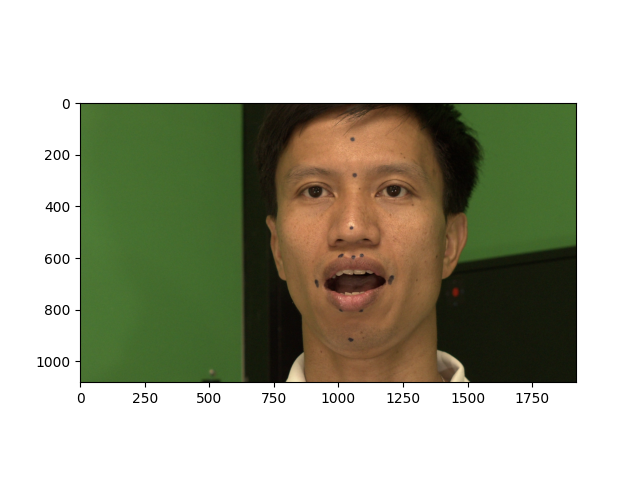

<IPython.core.display.Javascript object>


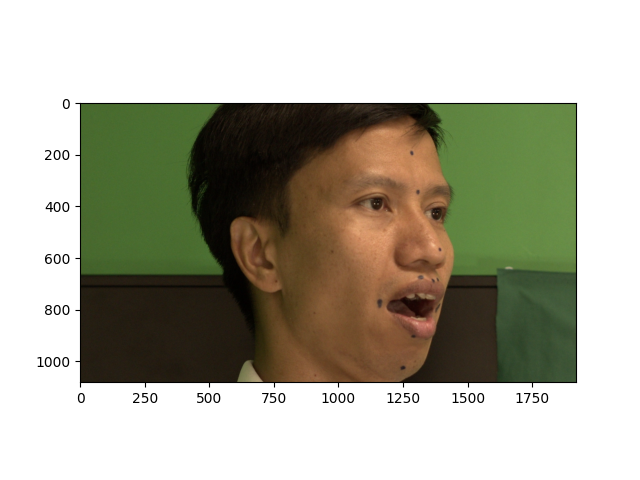

<IPython.core.display.Javascript object>


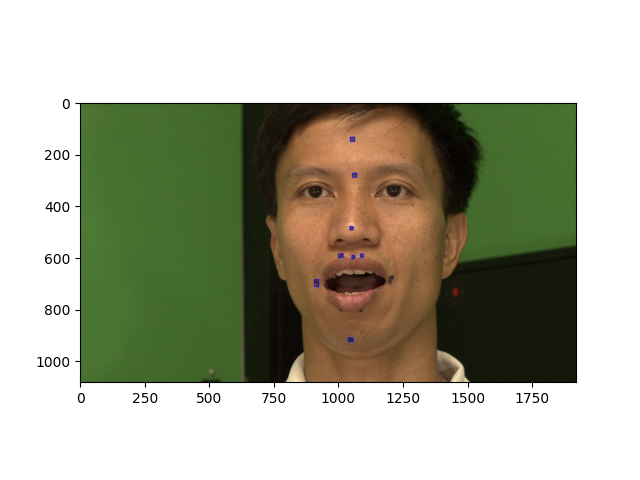

<IPython.core.display.Javascript object>


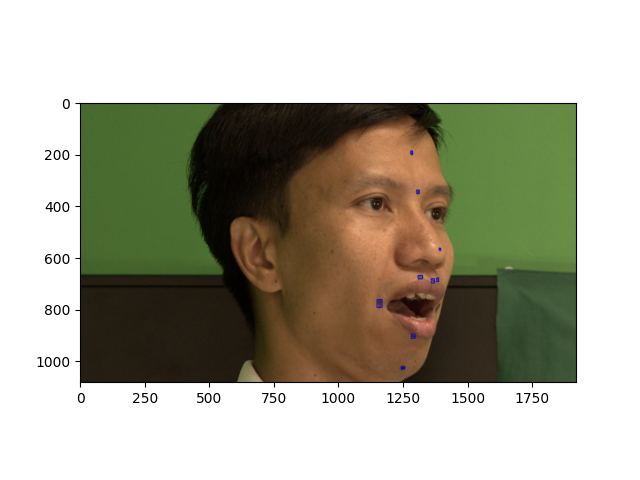

In [4]:
def listFullPaths(folder):
    
    paths = []
    for filename in sorted(os.listdir(folder)):
        path = os.path.join(folder, filename)
        paths.append(path)
        
    return paths

training = {}
training['side'] = listFullPaths('./data/training/segmented1/left')
training['front'] = listFullPaths('./data/training/segmented1/centre')

labels = {}
labels['side'] = listFullPaths('./data/training/segmented1/left_labels')
labels['front'] = listFullPaths('./data/training/segmented1/centre_labels')

image_front = cv2.imread(training['front'][0])
image_side = cv2.imread(training['side'][0])
label_front = MarkerDetection()
label_side = MarkerDetection()
label_front.load(labels['front'][0])
label_side.load(labels['side'][0])

plt.figure()
plt.imshow(image_front[..., [2,1,0]])

plt.figure()
plt.imshow(image_side[..., [2,1,0]])

label_front.display()
label_side.display()

<IPython.core.display.Javascript object>


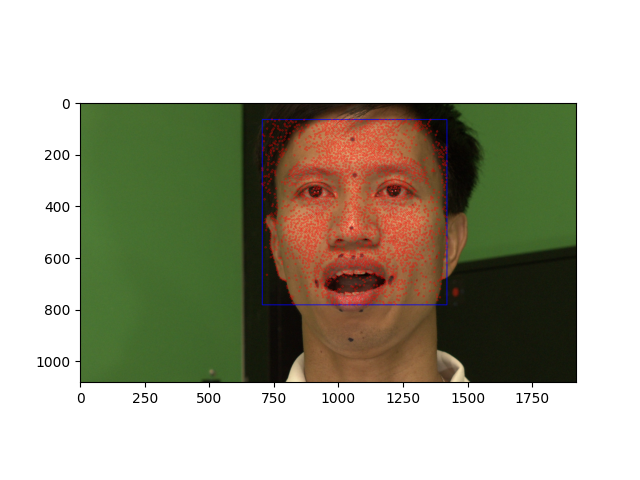

<IPython.core.display.Javascript object>


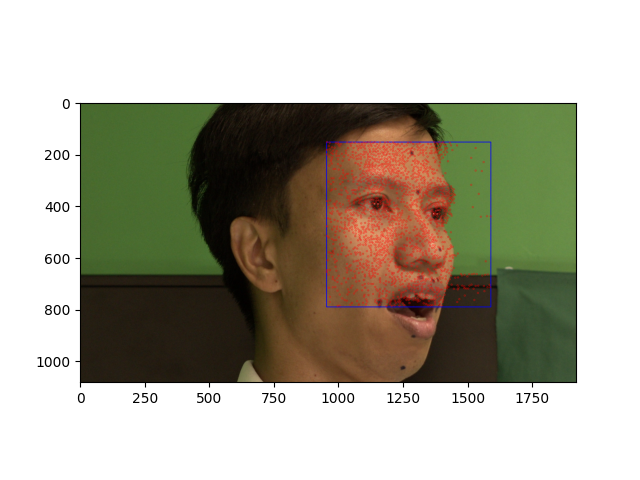

In [5]:
frame_front = Frame(image_front)
frame_front.detect(detectFace=True)

frame_side = Frame(image_side)
frame_side.detect(detectFace=True)

for frame in [frame_front, frame_side]:
    kptsImg = frame.getKeypointsVisual()
    
    plt.figure()
    plt.imshow(kptsImg[...,[2,1,0]])

<IPython.core.display.Javascript object>


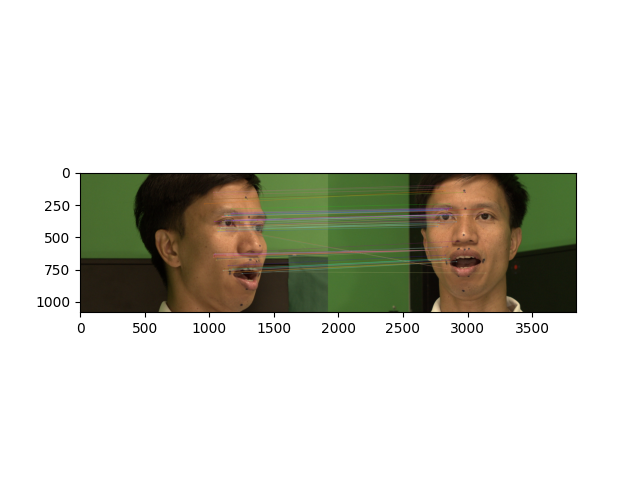

In [6]:
frameMatcher = FrameMatcher()
matches, matchesMask = frameMatcher(frame_side, frame_front, loweratio=0.9, homography=False)
FrameMatcher.display(frame_side, frame_front, matches, matchesMask)

As seen above, we generate a nice set of correspondences which we can triangulate and project to 3D, but there are still some incorrect correspondences. Epipolar geometry tells us that any given point on the left view is constrained to a line on the right view, the diagram below illustrates this.

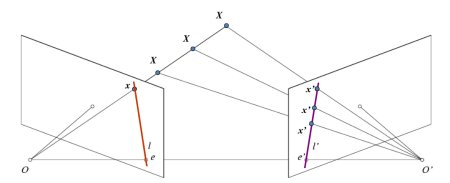

By exploiting this fact, we can filter out the spurious matches. The function below computes the epipolar line on the right view, for every given point on the left view, and filter out corresondences that deviates too far from their epiline.

<IPython.core.display.Javascript object>


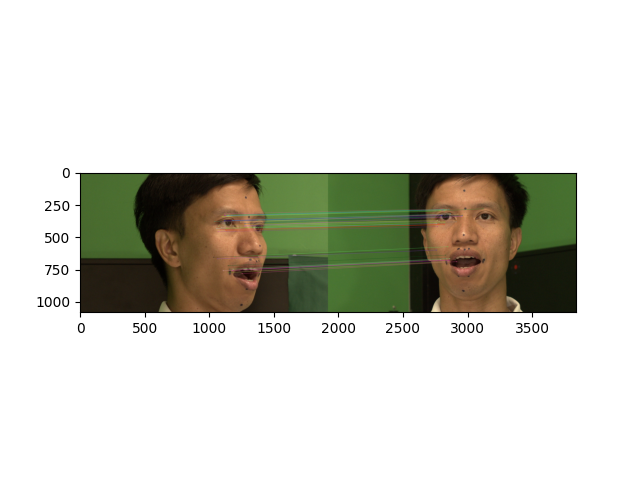

In [7]:
epipolarMask = np.copy(matchesMask)
for i, match in enumerate(matches):
    if epipolarMask[i] == 0:
        continue
    
    pt_src = frame_side.kps[match[0].queryIdx].pt
    pt_dst = frame_front.kps[match[0].trainIdx].pt
    
    # undistort these points
    pt_src = calibration.undistort_points([pt_src], view='right').squeeze()
    pt_dst = calibration.undistort_points([pt_dst], view='left').squeeze()
    
    pt_dst = pt_dst[np.newaxis, ...]  # junk to make this work if my code wasn't so bad
    line = calibration.compute_correspond_epilines(pt_dst, view='right').squeeze()

    d = distance_from_line(pt_src, *line)
    if d > 10.0:
        epipolarMask[i][0] = 0  # mask this point
        
FrameMatcher.display(frame_side, frame_front, matches, epipolarMask)

## Triangulation

The correspondences can be triangulated using our calibration to determine their coordinates in the camera's view

<IPython.core.display.Javascript object>


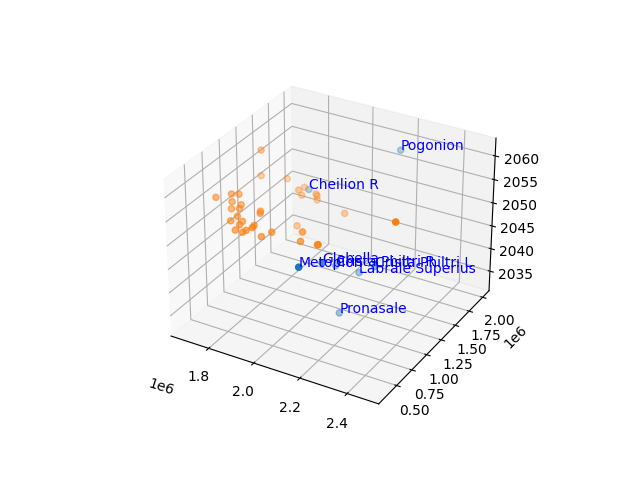

In [8]:
# Triangulate keypoints
inferheadmodel_front = HeadModel3D()
inferheadmodel_side = HeadModel3D()
pt3d = []
for i, match in enumerate(matches):
    if epipolarMask[i] == 0:
        continue
        
    pt_src = frame_side.kps[match[0].queryIdx].pt
    pt_dst = frame_front.kps[match[0].trainIdx].pt
    
    # undistort these points
    pt_src = calibration.undistort_points([pt_src], view='right').squeeze()
    pt_dst = calibration.undistort_points([pt_dst], view='left').squeeze()
    
    X, X1, X2 = calibration.triangulate(pt_dst, pt_src) # src and dst is swap because calibration inverse camera definitions
    pt3d.append(X1.flatten())
    
    inferheadmodel_front.addFeaturePoint(X1.flatten(), frame_front.des[match[0].trainIdx])
    inferheadmodel_side.addFeaturePoint(X1.flatten(), frame_side.des[match[0].queryIdx])
    
pt3d = np.array(pt3d, dtype=np.float32)

# Triangulate landmarks
landmarks = []
names = []
for name in label_side.bboxes.keys():
    if name in label_front.bboxes:
        names.append(name)
        pt_src = find_bbox_centre(label_side.bboxes[name])
        pt_dst = find_bbox_centre(label_front.bboxes[name])
        
        # undistort these points
        pt_src = calibration.undistort_points([pt_src], view='right').squeeze()
        pt_dst = calibration.undistort_points([pt_dst], view='left').squeeze()

        X, X1, X2 = calibration.triangulate(pt_dst, pt_src)  # src and dst is swap because calibration inverse camera definitions
        landmarks.append(X1.flatten())

landmarks = np.array(landmarks, dtype=np.float32)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(landmarks[:,0], landmarks[:,1], landmarks[:,2])
ax.scatter(pt3d[:,0], pt3d[:,1], pt3d[:,2])

for i, name in enumerate(names):
    pt = landmarks[i,:3]
    ax.text(*pt, name, color='blue')

## Create headmodel from triangulated point

In [9]:




# Display 3D
inferheadmodel_front.display()
headmodel_front.display()

# Display 2D
frameMatcher = FrameMatcher()
matches, mask = frameMatcher(modelframe_front, frame_front, loweratio=1)
FrameMatcher.display(modelframe_front, frame_front, matches, mask=mask)

# M
matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
matches = matcher.knnMatch(inferheadmodel_front.descriptors, headmodel_front.descriptors, 2)

goodmatches = []
for i, knnmatch in enumerate(matches):
    m, n = knnmatch[:2]
    if m.distance < 0.95 * n.distance:
        goodmatches.append(m)
        

SyntaxError: invalid syntax (<ipython-input-9-46a2e19b3fe7>, line 26)

<IPython.core.display.Javascript object>


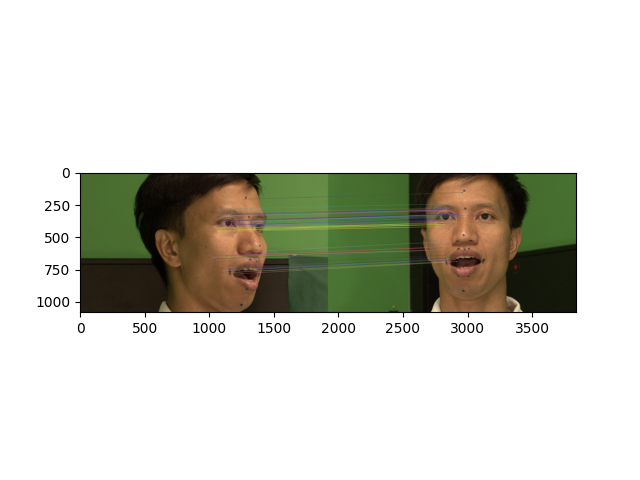

<IPython.core.display.Javascript object>


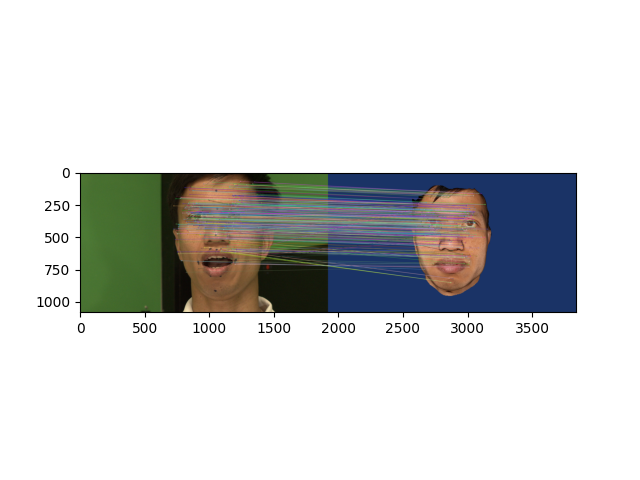

<IPython.core.display.Javascript object>


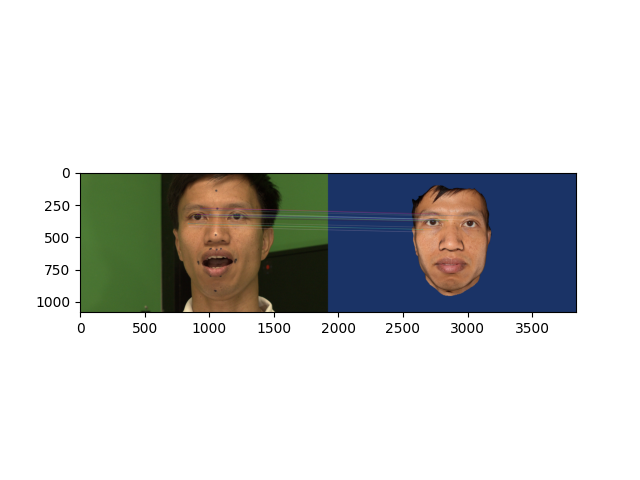

In [13]:
def lowe_ratio_filter(knnmatches, loweratio=0.7):
    
    good = []
    for knnmatch in knnmatches:
        m, n = knnmatch[:2]  # get the 1st and 2nd closest
        if m.distance < loweratio * n.distance:
            good.append([m])
            
    return good

def display_matches(matches, queryimg, querykps, trainimg, trainkps):
    vis = cv2.drawMatchesKnn(queryimg, querykps, 
                             trainimg, trainkps, 
                             matches,
                             None,
                             flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure()
    plt.imshow(vis[...,[2,1,0]])
    plt.show()


matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

# ---------- 1st step: FIND CORRESPONDENCES BETWEEN STEREO IMAGES ---------- 

stereomatches = matcher.knnMatch(frame_side.des, frame_front.des, 2)

# Lowe ratio filtering
loweratio = 0.9
stereomatches = lowe_ratio_filter(stereomatches, loweratio)

# Epipolar constraint
epipolar_threshold = 20.0
good = []
for match in stereomatches:

    pt_src = frame_side.kps[match[0].queryIdx].pt
    pt_dst = frame_front.kps[match[0].trainIdx].pt
    
    # undistort these points
    pt_src = calibration.undistort_points([pt_src], view='right').squeeze()
    pt_dst = calibration.undistort_points([pt_dst], view='left').squeeze()
    
    pt_dst = pt_dst[np.newaxis, ...]  # junk to make this work if my code wasn't so bad
    line = calibration.compute_correspond_epilines(pt_dst, view='right').squeeze()

    d = distance_from_line(pt_src, *line)
    if d < epipolar_threshold:
        good.append(match)
stereomatches = good

# display result
display_matches(stereomatches, frame_side.image, frame_side.kps, frame_front.image, frame_front.kps)

# ---------- 2nd step: FIND CORRESPONDENCES BETWEEN CENTRE IMAGE AND HEAD MODEL ---------- 
modelmatches = matcher.knnMatch(frame_front.des, headmodel_front.descriptors, 2)

# Lowe ratio filtering
loweratio = 0.95
modelmatches = lowe_ratio_filter(modelmatches, loweratio)

# display result
display_matches(modelmatches, frame_front.image, frame_front.kps, modelframe_front.image, modelframe_front.kps)

# ---------- 3rd step: 3-WAY MATCHING BETWEEN STEREO MODEL & VECTRA 3D MODEL ----------

stereomatches = sorted(stereomatches, key=lambda match: match[0].trainIdx)
modelmatches = sorted(modelmatches, key=lambda match: match[0].queryIdx)

i, j = 0, 0
threewaymatches = []
while i < len(stereomatches) and j < len(modelmatches):
    
    if stereomatches[i][0].trainIdx == modelmatches[j][0].queryIdx:
        threewaymatches.append((stereomatches[i], modelmatches[j]))
        j += 1
        i += 1
    elif stereomatches[i][0].trainIdx < modelmatches[j][0].queryIdx:
        i += 1
    else:
        j += 1
        
# display result
stereomatches3way = []
modelmatches3way = []
for stereomatch3way, modelmatch3way in threewaymatches:
    stereomatches3way.append(stereomatch3way)
    modelmatches3way.append(modelmatch3way)
    
display_matches(modelmatches3way, frame_front.image, frame_front.kps, modelframe_front.image, modelframe_front.kps)

